In [ ]:
# SETUP SPARK
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import logging
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("SmartLogiTrack").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")  # only errors
logging.getLogger("py4j").setLevel(logging.ERROR)

26/01/12 15:38:52 WARN Utils: Your hostname, chaima-ThinkPad-T470-W10DG resolves to a loopback address: 127.0.1.1; using 192.168.1.113 instead (on interface wlp4s0)
26/01/12 15:38:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/12 15:38:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#READ DATA
df = spark.read.parquet("data/dataset.parquet")
print("Raw data preview:")
df.show(5)
print("Schema:")
df.printSchema()


Raw data preview:


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [ ]:
#CALCULATE DURATION IN MINUTES
df = df.withColumn(
    "duration_minutes",
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60
)
df.select("duration_minutes").show(5)


+-----------------+
| duration_minutes|
+-----------------+
|             8.35|
|             2.55|
|             1.95|
|5.566666666666666|
|3.533333333333333|
+-----------------+
only showing top 5 rows



In [ ]:
#HANDLE MISSING VALUES
df = df.fillna({
    "passenger_count": 1,
    "RatecodeID": 1,
    "store_and_fwd_flag": "N",
    "congestion_surcharge": 0,
    "Airport_fee": 0
})

In [ ]:
#FILTER BAD DATA
df = df.filter(
    (F.col("duration_minutes") > 0) &
    (F.col("trip_distance") > 0) &
    (F.col("trip_distance") <= 200) &
    (F.col("passenger_count") > 0)
)

In [ ]:
#FEATURE ENGINEERING
df = df.withColumn("pickuphour", F.hour("tpep_pickup_datetime"))
df = df.withColumn("dayof_week", F.dayofweek("tpep_pickup_datetime"))
df = df.withColumn("month", F.month("tpep_pickup_datetime"))

In [ ]:
#REMOVE DUPLICATES
rows_before = df.count()
df = df.dropDuplicates()
rows_after = df.count()
print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Duplicates removed:", rows_before - rows_after)


Rows before: 3359200
Rows after: 3359200
Duplicates removed: 0


In [ ]:
numeric_cols = [
    "VendorID", "passenger_count", "trip_distance", "RatecodeID",
    "PULocationID", "DOLocationID", "payment_type",
    "fare_amount", "extra", "mta_tax", "tip_amount",
    "tolls_amount", "improvement_surcharge", "total_amount",
    "congestion_surcharge", "Airport_fee", "cbd_congestion_fee",
    "duration_minutes"
]

In [ ]:
# Sample 10% for plotting
pdf = df.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()


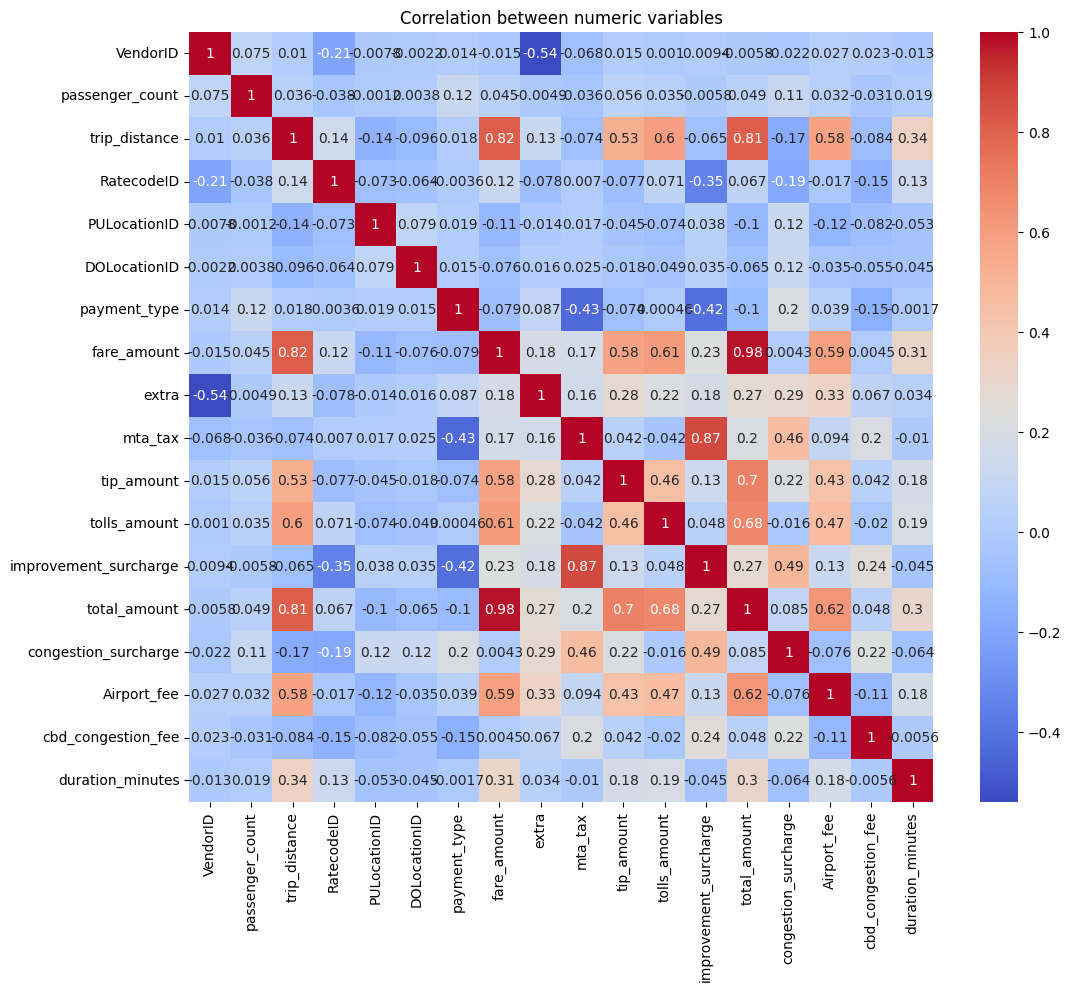

In [ ]:
#CORRELATION MATRIX
corr = pdf.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation between numeric variables")
plt.show()


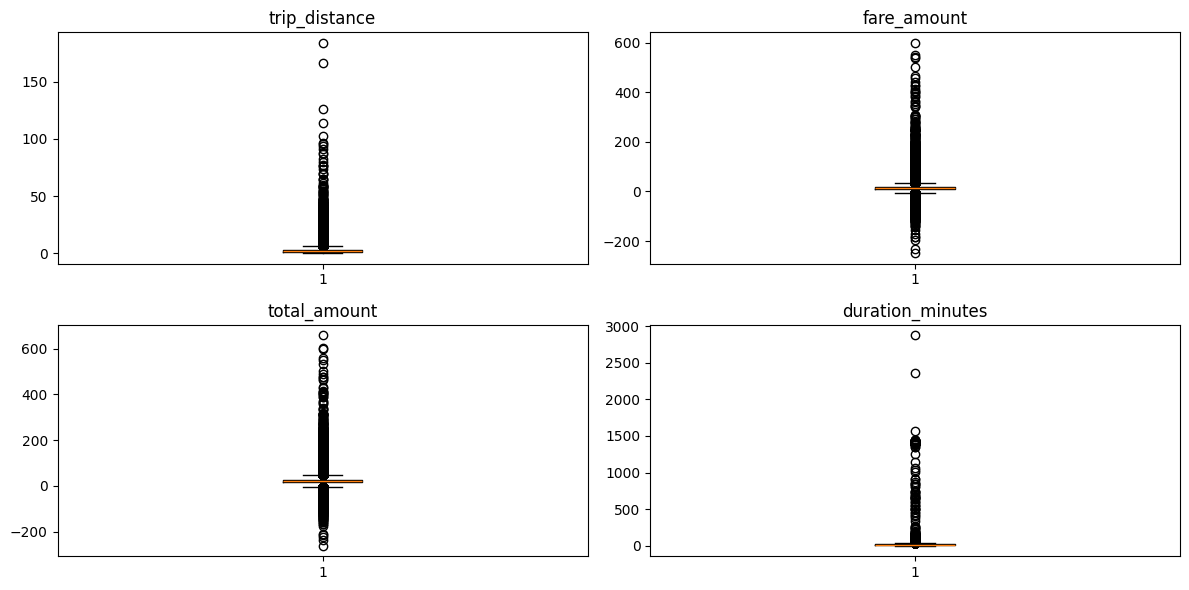

In [ ]:
#BOXPLOTS FOR NUM COLS
cols = ["trip_distance", "fare_amount", "total_amount", "duration_minutes"]
plt.figure(figsize=(12, 6))
for i, c in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(pdf[c].dropna())
    plt.title(c)
plt.tight_layout()
plt.show()

In [ ]:
#REMOVE OUTLIERS (IQR METHOD)
def remove_outliers_iqr(df, column, k=1.5):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return df.filter((F.col(column) >= lower) & (F.col(column) <= upper))

for c in ["trip_distance", "fare_amount", "total_amount", "duration_minutes"]:
    df = remove_outliers_iqr(df, c)
print("Rows after outlier removal:", df.count())


Rows after outlier removal: 2682649


In [ ]:
#SAVE SILVER DATA
df.coalesce(1).write.mode("overwrite").parquet("data/silver_taxi_data")

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
#load data
df = pd.read_parquet("data/silver_taxi_data")

#features and Target
features = ["pickuphour", "dayof_week", "month", "congestion_surcharge",
            "trip_distance", "PULocationID", "DOLocationID",
            "cbd_congestion_fee", "total_amount"]
X = df[features]
y = df["duration_minutes"]

#spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

#evaluate
predictions = rf.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE = {mae:.4f}, R² = {r2:.4f}")

#saving
joblib.dump(rf, "models/taxi_duration_model.pkl")
print("Model saved as .pkl")

Model saved as .pkl
